In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Cryptocurrency Hacks

Below is a compilation of data obtained from the internet about documented cases of cryptocurrency hacks. Analysis of this data reveals a few key take aways: <br>

- While the number of hacks per year has been increasing, the ratio relative to the number of exchanges in operation has been decreasing (Figure 1).
- Similarly, while the cost of hacks has been increaseing, the amount relative to the total market cap has been decreasing (Figure 3).
- 66% of hack involved funds being stolen from a hot wallet, compared to 5% for cold wallets. 



Files: <br>
CryptoHacks_coded_cleaned_nov2018.csv  -  Contains data about cryptocurrency hacks
btc_historic_price.csv                 -  Contains btc price and market cap data from blockchain.com
MTurk/ExchangeFoundedDates.csv         -  Contains crowd sourced data on when cryptocurrency exchanges were founded

In [2]:
import requests
import pandas as pd
import numpy as np
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# LOAD MARKETCAP DATA
df = pd.read_csv('CryptoHacks_coded_cleaned_nov2018.csv')
df_charts = pd.read_csv('btc_historic_price.csv')

# Convert 'year' into datetime format
df['date'] = df['year'].apply(lambda x : datetime.datetime.strptime('20' + x, '%Y-%b'))

# Convert date format in charts data
df_charts['dateNew'] = df_charts['date'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d'))

In [4]:
# LOAD EXCHANGE DATA
df_exch_data = pd.read_csv('MTurk/ExchangeFoundedDates.csv')
df_exchanges = pd.DataFrame()

# Find the number of exchanges in existence each year
for year in range(2011,2019):
    nExchanges = sum(df_exch_data['yearFounded'].values <= year)
    df_exchanges = df_exchanges.append({'year':year, 'nExchanges':nExchanges}, ignore_index=True)

In [5]:
# PLOTTING FUNCTIONS

# Scatter plot formatting
def plot_by_group(ax,grp_variable):
    # Loop through groups 
    groups = df.groupby(grp_variable)
    for name, group in groups:
        ax.plot(group.date, group.logLoss, marker='o', linestyle='', alpha = 0.8, ms=12, label=name)
    ax.legend()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.yaxis.set_major_formatter(logFormatter) # set y axis to log units
    plt.show()
    
    
# Format the x axis into millions of USD
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)    
    

# Format the x axis into log of USD
def logmillions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (np.exp(x)*1e-6)

In [6]:
# GET BTC SUPPLY, PRICE AND MARKETCAP

df["btcPrice"] = np.nan
df["btcMarketCap"] = np.nan

for idx, row in df.iterrows():
    
    # find which row of the charts data is the closest in time to the data
    diffs = abs( df_charts['dateNew'][:]+datetime.timedelta(0.1) - df['date'][idx]) 

    closestIndex = diffs[:] <  datetime.timedelta(1)
    
    # save values
    df["btcPrice"][idx] = df_charts[closestIndex] ['price'] .values
    df["btcMarketCap"][idx] = df_charts[closestIndex] ['marketCap'] .values

In [7]:
# CONVERTING VARIABLE FORMATS

# Turn loss USD into a float
df["lossUSD"] = df["lossUSD"].str.replace(",","").astype(float)

# Create relative loss 
df['relLoss'] = df["lossUSD"]/df["btcMarketCap"]

# Create log loss 
df['logLoss'] = np.log(df['lossUSD'])

# Create log MarketCap 
df['logMarket'] = np.log(df['btcMarketCap'])
df_charts['logMarket'] = np.log(df_charts['marketCap'])

# Create log MarketCap 
df['logPrice'] = np.log(df['btcPrice'])

First few rows of the data

In [8]:
df.head()

,incident,year,lossUSD,organisation,hackType,userDataCompromised,walletType,date,btcPrice,btcMarketCap,relLoss,logLoss,logMarket,logPrice
0,Bitcoin7,11-Oct,50000.0,exchange,serverHacked,1,hot,2011-10-01,5.3500,3.946588e+07,0.001267,10.819778,17.490947,1.677097
1,Mt. Gox,11-Jun,8750000.0,exchange,humanError,0,hot,2011-06-01,9.4998,6.071655e+07,0.144112,15.984564,17.921727,2.251271
2,Bitcoinica,12-Jul,650000.0,exchange,serverHacked,1,hot,2012-07-01,6.6930,6.255679e+07,0.010391,13.384728,17.951585,1.901062
3,Bitfloor,12-Sep,250000.0,exchange,serverHacked,na,hot,2012-09-01,10.8359,1.065055e+08,0.002347,12.429216,18.483707,2.382865
4,Vicurex,13-May,160000.0,exchange,serverHacked,0,hot,2013-05-01,139.1090,1.543898e+09,0.000104,11.982929,21.157576,4.935258


### Figure 1. Number of hacks over years, and relative to number of exchanges
<br>
While the total frequency of hacks has been increasing (Top Left), the number of exchanges in operation has also been increasing (Top Right). As a result, the frequency of hacks relative to the number of echanges has been decreasing (Bottom Left).

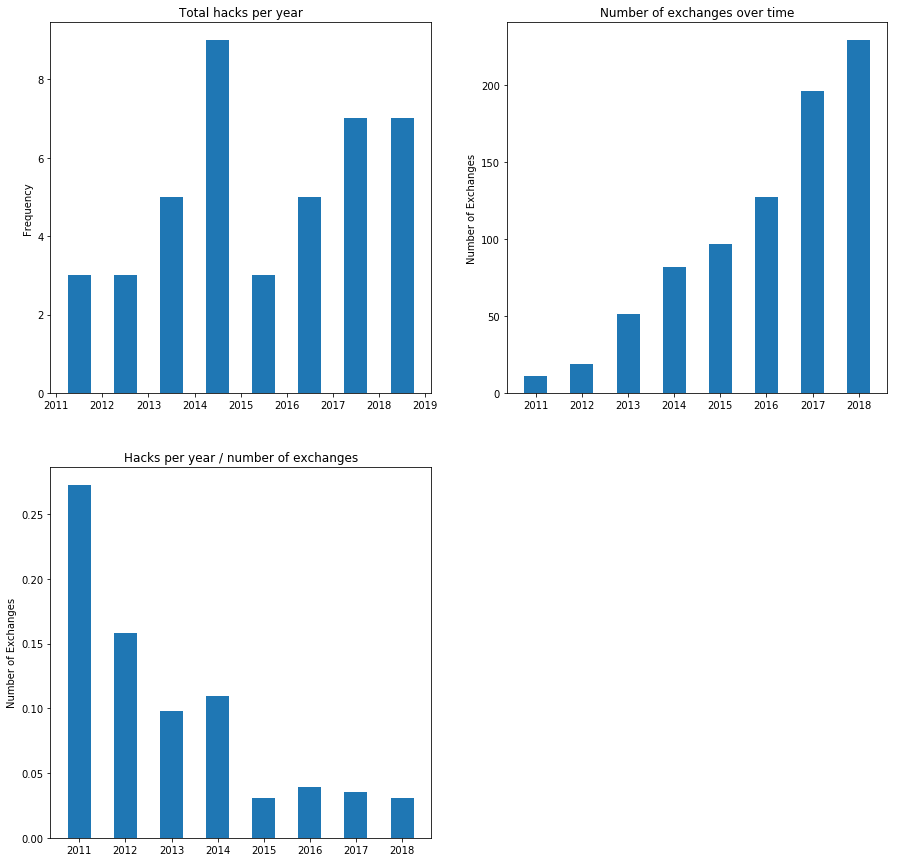

In [9]:
# Create two subplots
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(15, 15))

# Subplot 1 - Hacks per year
yearData = (df["date"].dt.year) # extract year from date
counts, bins, bars = ax1.hist(yearData,bins=range(2011, 2020), rwidth=0.5)
# Format axes and title
ax1.set_ylabel('Frequency')
ax1.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax1.set_title('Total hacks per year')

# Subplot 2 - Number of exchanges each year
ax2.bar(df_exchanges['year'], df_exchanges['nExchanges'], width=0.5)
# Format axes and title
ax2.set_ylabel('Number of Exchanges')
ax2.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax2.set_title('Number of exchanges over time')
              
# Subplot 3 - Hacks as a ratio of number of exchanges
ax3.bar(df_exchanges['year'], counts/df_exchanges['nExchanges'], width=0.5)
# Format axes and title
ax3.set_ylabel('Number of Exchanges')
ax3.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax3.set_title('Hacks per year / number of exchanges')
              
           
ax4.axis('off');

### Figure 2. Distribution of USD lost in hacks is skewed
<br>
The distribution of losses in hacks is highly skewed, with many relatively small losses and a few big losses (Left). A log scale is better at capturing the distribution (Right).

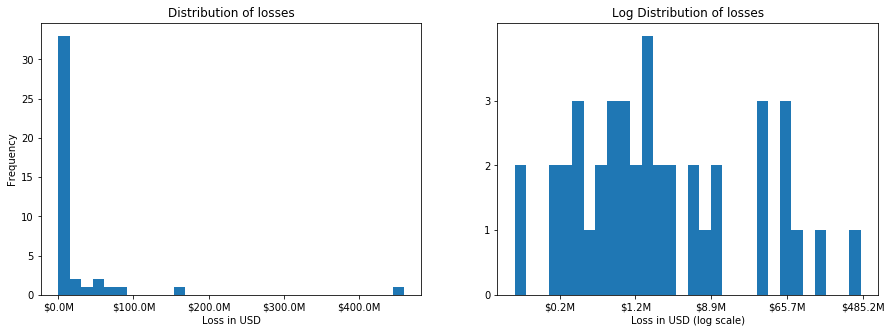

In [10]:
# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1
ax1.hist(df['lossUSD'],bins=30)
# Format axes and title
ax1.set_xlabel('Loss in USD')
ax1.set_ylabel('Frequency')
ax1.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax1.set_title('Distribution of losses')

formatter = FuncFormatter(millions)
ax1.xaxis.set_major_formatter(formatter)


# Subplot 2
# Histogram of hacked amount (log scale)
ax2.hist(df['logLoss'],bins=30)
# Format axes and title
ax2.set_xlabel('Loss in USD (log scale)')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_yticks(np.arange(0, 4, step=1))
ax2.set_title('Log Distribution of losses')

logFormatter = FuncFormatter(logmillions)
ax2.xaxis.set_major_formatter(logFormatter)

### Figure 3a. Timing of hacks relative to BTC market cap

By eye, it appears that hacks are most frequent following a bull run.

Small black points - BTC Market Cap values for each month <br>
Red circles - Timing of hacks relative to the Market Cap price <br>

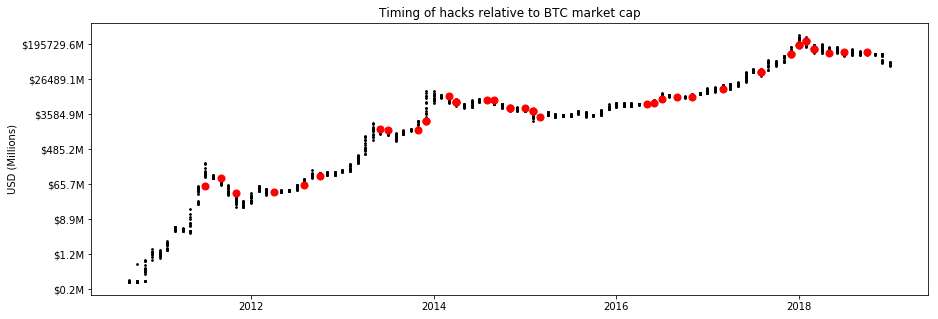

In [11]:
# BTC Market Cap data (black dots)
dateYears = (df_charts["dateNew"].dt.year) +(df_charts["dateNew"].dt.month)/12  # convert date into years
x_data = np.transpose([dateYears])
y_data = df_charts['logMarket']

# Timing of hack data (red dots)
dateYears2 = (df["date"].dt.year) +(df["date"].dt.month)/12  # convert date into years
x2_data = np.transpose([dateYears2])
y2_data = df['logMarket']

# Plot data
fig, ax = plt.subplots(figsize=(15, 5)); # Set figure size
plt.scatter(x_data, y_data,  color='black', s=3);
plt.scatter(x2_data, y2_data,  color='red', s=50, marker="o");

# convert y axis to log values
logFormatter = FuncFormatter(logmillions)
ax.yaxis.set_major_formatter(logFormatter)

plt.title('Timing of hacks relative to BTC market cap')
plt.ylabel('USD (Millions)');


### Figure 3b.  Absolute amount lost in USD per hack is increasing over time

Coefficients: 
 [0.43014278]


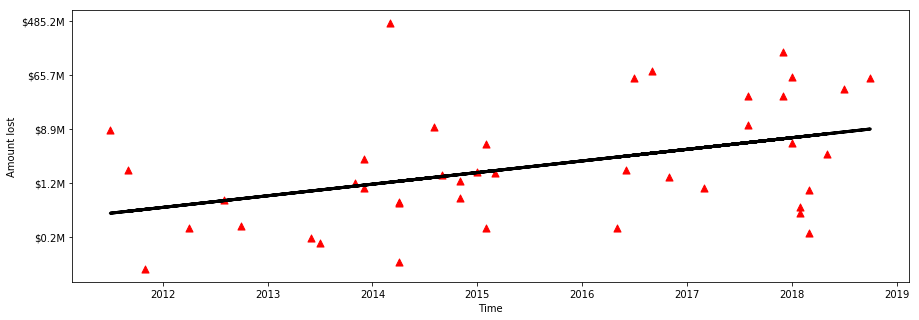

In [12]:
# Define x and y data
dateYears = (df["date"].dt.year) +(df["date"].dt.month)/12  # convert date into years
x_data = np.transpose([dateYears])
y_data = df['logLoss']

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr.fit(x_data, y_data)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Make predictions using the testing set
y_pred = regr.predict(x_data)

# Plot outputs
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(x_data, y_data,  color='red', s=50, marker="^")
plt.plot(x_data, y_pred, color='black', linewidth=3)

plt.xlabel('Time')
plt.ylabel('Amount lost')
ax.yaxis.set_major_formatter(logFormatter)

plt.show()

### Figure 3c. Amount lost per hack is actually decreasing relative to market cap

Y-axis is the proportion of BTC lost relative to the total supply at the time*

*Includes losses of other non BTC crypto assets (e.g. ETH). However the non-BTC amounts are not substantial.

Coefficients: 
 [-0.00397899]


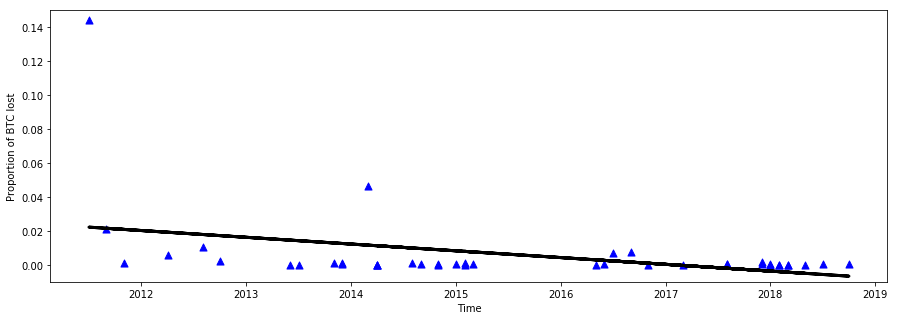

In [13]:
# Define x and y data
dateYears = (df["date"].dt.year) +(df["date"].dt.month)/12  # convert date into years
x_data = np.transpose([dateYears])
y_data = df['relLoss']

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr.fit(x_data, y_data)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Make predictions using the testing set
y_pred = regr.predict(x_data)

# Plot outputs
fig, ax = plt.subplots(figsize=(15, 5))
plt.xlabel('Time')
plt.ylabel('Proportion of BTC lost')

plt.scatter(x_data, y_data, color='blue', s=50, marker="^")
plt.plot(x_data, y_pred, color='black', linewidth=3)
plt.ylim((-0.01,0.15))
plt.show()

### Figure 3d. Correlation above still holds even when removing top two outliers (Mt Gox incidences)

n.b. change the value of n below to remove n number of largest values.

Coefficients: 
 [-0.00075957]


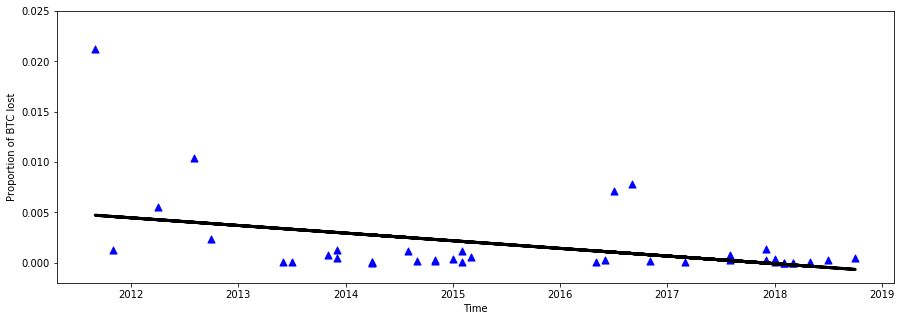

In [14]:
# REMOVE N NUMBER OF LARGEST VALUES (top two are MtGox 2011, 2014)
n=2

# Define x and y data
dateYears = (df["date"].dt.year) +(df["date"].dt.month)/12  # convert date into years
x_data = np.transpose([dateYears])
y_data = df['relLoss']

# Remove n high values
idx = (-y_data).argsort()[:n]
y_data = y_data.drop(idx)
x_data = np.delete(x_data, idx, 0)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr.fit(x_data, y_data)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Make predictions using the testing set
y_pred = regr.predict(x_data)

# Plot outputs
fig, ax = plt.subplots(figsize=(15, 5))
plt.xlabel('Time')
plt.ylabel('Proportion of BTC lost')

plt.scatter(x_data, y_data,   color='blue', s=50, marker="^")
plt.plot(x_data, y_pred, color='black', linewidth=3)
plt.ylim((-0.002,0.025))
# plt.autoscale(enable=True, axis='y')
plt.show()

### Figure 3e. Proportion of BTC lost is negatively correlated with market cap

Coefficients: 
 [-0.00079593]


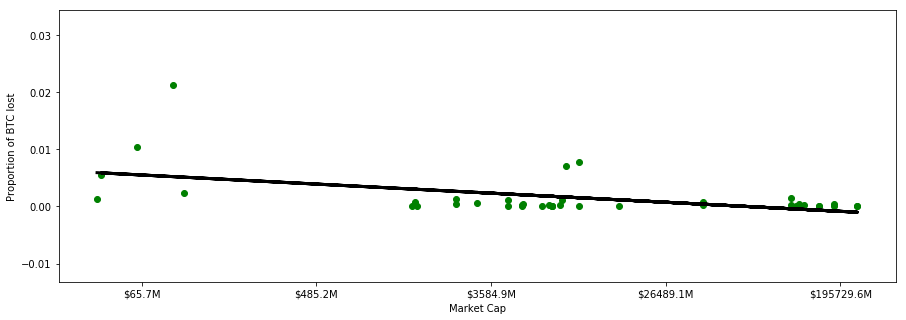

In [15]:
# REMOVE N NUMBER OF LARGEST VALUES (top two are MtGox 2011, 2014)
n=2

# Define x and y data
x_data = df['logMarket'].values
x_data = np.reshape(x_data, (len(x_data), 1))

y_data = df['relLoss']

# Remove n high values
idx = (-y_data).argsort()[:n]
y_data = y_data.drop(idx)
x_data = np.delete(x_data, idx, 0)


# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr.fit(x_data, y_data)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Make predictions using the testing set
y_pred = regr.predict(x_data)

# Plot outputs
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(x_data, y_data,  color='green')
plt.plot(x_data, y_pred, color='black', linewidth=3)

# convert x axis to log values
logFormatter = FuncFormatter(logmillions)
ax.xaxis.set_major_formatter(logFormatter)
# Label axis
plt.xlabel('Market Cap')
plt.ylabel('Proportion of BTC lost')

plt.show()

### Figure 4. Type of hack over time and amount.
Human errors were more common in the past (before 2015)

Bugs are playing a larger role in modern hacks. This is mainly due to bugs in Ethereum smart contracts.

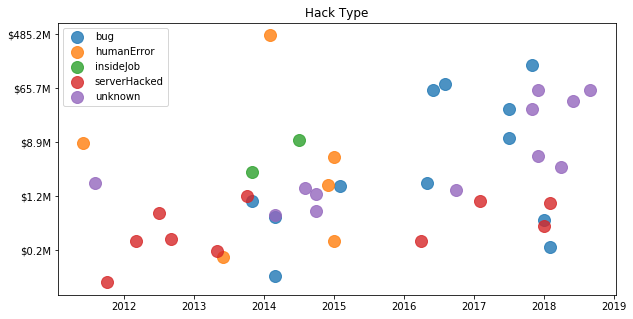

In [16]:
fig, ax = plt.subplots(figsize=(10, 5)) # Set figure size
plt.title('Hack Type')
plot_by_group(ax,'hackType')

### Figure 5. Type of organisation hacked over time and amount.

Cryptocurrency exchanges make up the majority of (reported) hacked organisations. Smart contracts hacks have been responsible for some of the largest recent hacks.

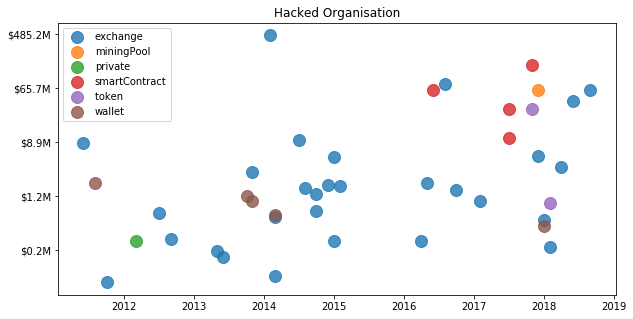

In [17]:
fig, ax = plt.subplots(figsize=(10, 5)) # Set figure size
plt.title('Hacked Organisation')
plot_by_group(ax,'organisation')

### Figure 6a. Two thirds of hacks involved hot wallets
*na refers to unknown cases or cases where it is not applicable, e.g. a smart contract being hacked.

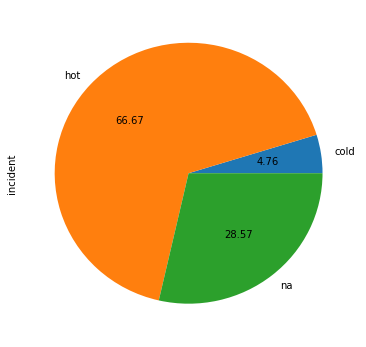

In [18]:
# Percentage of hot or cold wallets. na is information not available, or not applicable (e.g. DAO hack)
walletCounts = df.groupby(df["walletType"]).count();
walletCounts.incident.plot(kind="pie",figsize=(6, 6),autopct='%.2f');

### Figure 6b. Wallet type hacked over date and amount
<br>
No clear trends in wallet type involved in hacks over time.

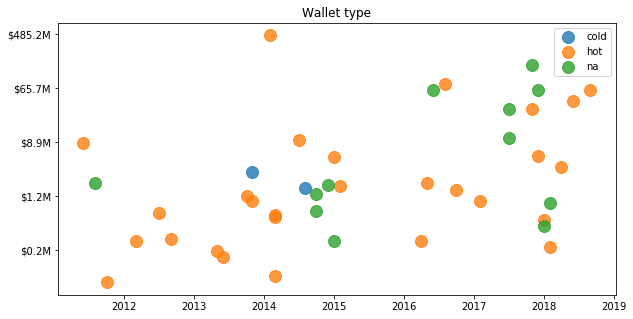

In [19]:
# Hacks grouped by wallet type
fig, ax = plt.subplots(figsize=(10, 5)) # Set figure size
plt.title('Wallet type')
plot_by_group(ax,'walletType')